## Test Time Augmentation

After training our model on the provided images, we would like to generate predictions for the separate test set. Unfortunately, our test images are about 1200x310 and our model can only handle 256x256 inputs.

We can work around this by taking multiple slices of the image, running them through the model and then storing the predictions for each slice.

Some other thoughts:
- How far should we move the 256x256 input when making each set of predictions?
- Is there an intelligent way to average predictions from overlapping slices?
- How do we ensemble predictions from multiple models?

In [1]:
import os
import PIL
import math
import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import FloatTensor, LongTensor, tensor

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.patheffects as patheffects

from RetinaNet.object_detection_helper import process_output, nms, rescale_boxes, show_results

import fastai
from fastai.core import is_tuple
from fastai.torch_core import to_np
from fastai.basic_train import _loss_func2activ, validate, progress_bar, loss_batch
from fastai.vision.data import pil2tensor
from fastai.vision import Path, open_image, ImageBBox, ObjectItemList, get_transforms, bb_pad_collate, conv_layer, Learner, create_body, models, conv2d, ifnone, DatasetType, range_of, progress_bar, ShowGraph, get_preds, Image

In [2]:
#from RetinaNet.object_detection_helper import 
from RetinaNet.object_detection_helper import create_anchors, show_results_side_by_side, get_annotations_from_path
from RetinaNet.RetinaNetFocalLoss import FocalLoss
from RetinaNet.RetinaNet import RetinaNet
from RetinaNet.callbacks import BBLossMetrics, BBMetrics, PascalVOCMetric

In [3]:
DATA = Path('data/')
IMAGES = DATA/'train_labelled_images'
TEST_IMAGES = DATA/'sorghum_test_public'
ANNOTATIONS = DATA/'train_labelled_annotations'

In [4]:
images, lbl_bbox = get_annotations_from_path(ANNOTATIONS, IMAGES)
img2bbox = dict(zip(images, lbl_bbox))
get_y_func = lambda o:img2bbox[IMAGES/o.name]

In [5]:
def get_data(bs, size):
    src = ObjectItemList.from_folder(IMAGES)
    src = src.split_by_rand_pct(0.1)
    src = src.label_from_func(get_y_func)
    src = src.transform(get_transforms(), size=size, tfm_y=True)
    return src.databunch(path=IMAGES, bs=16, collate_fn=bb_pad_collate)

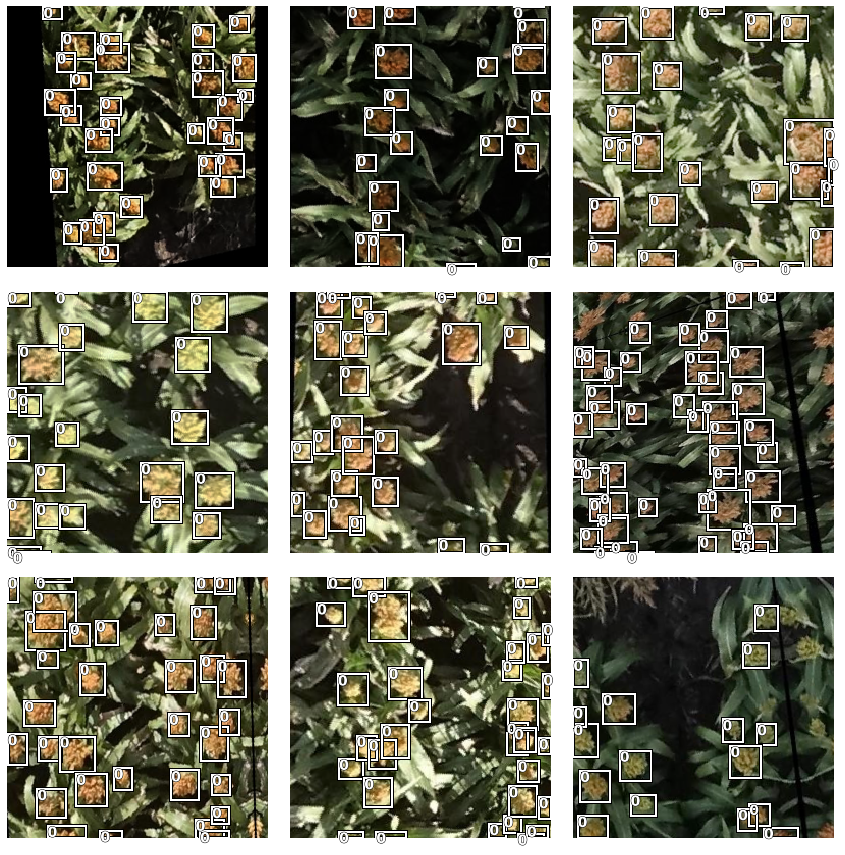

In [6]:
batch_size = 64
image_size = 256

data = get_data(batch_size, image_size)
data.show_batch(3)

In [7]:
#WARNING: Hardcoded anchor sizes probably not great for when we change things
anchors = create_anchors(sizes=[(16,16),(8,8),(4,4),(2,2)], ratios=[0.5, 1, 2], scales=[0.35, 0.5, 1])

In [8]:
n_classes = data.train_ds.c

crit = FocalLoss(anchors)

encoder = create_body(models.resnet18, True, -2)
model = RetinaNet(encoder, n_classes=data.train_ds.c, n_anchors=9, sizes=[16,8,4,2], chs=32, final_bias=-4., n_conv=2)

In [9]:
voc = PascalVOCMetric(anchors, image_size, [i for i in data.train_ds.y.classes[1:]])
learn = Learner(data, model, loss_func=crit)

In [10]:
learn.split([model.encoder[6], model.c5top5])
learn.freeze_to(-2)

In [11]:
learn.fit_one_cycle(20, 2e-3)

epoch,train_loss,valid_loss,time
0,2.818078,1.591850,00:05
1,2.063270,1.383211,00:04
2,1.708549,1.269644,00:04
3,1.499880,1.148756,00:04
4,1.507945,1.279122,00:04
5,1.371097,0.997987,00:04
6,1.238529,0.923091,00:04
7,1.126113,0.822114,00:04
8,1.032686,0.775599,00:04
9,0.957143,0.742230,00:04


In [12]:
learn.unfreeze()
learn.fit_one_cycle(50, slice(1e-4, 1e-3))

epoch,train_loss,valid_loss,time
0,0.624153,0.602588,00:04
1,0.618780,0.594197,00:04
2,0.616532,0.597259,00:04
3,0.614243,0.582690,00:04
4,0.612427,0.581061,00:04
5,0.606752,0.607953,00:04
6,0.600434,0.547998,00:04
7,0.595276,0.540005,00:04
8,0.590909,0.544943,00:04
9,0.581795,0.602603,00:04


In [132]:
def get_crop_coordinates(image_height, image_width, verticalCropIndex, horizontalCropIndex, model_input_size):
    
    maxVerticalCrops = int(np.ceil(image_height / model_input_size))
    maxHorizontalCrops = int(np.ceil(image_width / model_input_size))
    
    lastValidVerticalCrop = image_height - model_input_size
    lastValidHorizontalCrop = image_width - model_input_size
    
    crop_x = (horizontalCropIndex % maxHorizontalCrops) * model_input_size
    crop_x = min(crop_x, lastValidHorizontalCrop)
    
    crop_y = (verticalCropIndex % maxVerticalCrops) * model_input_size
    crop_y = min(crop_y, lastValidVerticalCrop)
    
    return crop_y, crop_x
    

#Overrides fastai's default 'open_image' method to crop based on our crop counter
def setupNewCrop(verticalCropIndex, horizontalCropIndex, model_input_size=256):
    
    def open_image_with_specific_crop(fn, convert_mode, after_open):
        """
        Opens an image with a specific crop, based on horizontalCropIndex and verticalCropIndex
        """
        
        x = PIL.Image.open(fn)
        width, height = x.size
        
        crop_y, crop_x = get_crop_coordinates(height, width, verticalCropIndex, horizontalCropIndex, model_input_size)
        
        cropped_image = x.crop([crop_x, crop_y, crop_x + model_input_size, crop_y + model_input_size])    
        
        # standardize    
        return Image(pil2tensor(cropped_image, np.float32).div_(255))

    #Override fastai's open_image() to use our custom open_image_with_specific_crop()
    fastai.vision.data.open_image = open_image_with_specific_crop

In [133]:
def getMaxHeightAndWidth(learn, ds_type=DatasetType.Valid):
    """
    Returns the maximum height and width for a given image dataset 
    """
    dl = learn.dl(ds_type)

    maxHeight = 0
    maxWidth = 0
    for i in dl.x:
        height = i.shape[1]
        width = i.shape[2]
        
        if height > maxHeight:
            maxHeight = height
            
        if width > maxWidth:
            maxWidth = width
        
    return maxHeight, maxWidth

In [214]:
def get_bounding_box_predictions(learn, dataloader, original_images, verticalCropIndex, horizontalCropIndex, detect_threshold = 0.5, nms_threshold = 0.1, model_input_size=256):
    """
    Generates bounding box predictions for an entire epoch of a provided Dataloader
    """
    all_imgs = []
    all_bboxes = []
    
    batch_index = 0
    
    for img_batch, target_batch in dataloader:
    
        prediction_batch = learn.model(img_batch)
        class_pred_batch, bbox_pred_batch = prediction_batch[:2]

        for index, (img, clas_pred, bbox_pred) in enumerate(zip(img_batch, class_pred_batch, bbox_pred_batch)):
            original_image = original_images[batch_index + index]
            
            #Filter out predictions below detect_thresh
            bbox_pred, scores, preds = process_output(clas_pred, bbox_pred, anchors, detect_threshold)
            
            #If there are no bounding boxes, we're done
            if len(bbox_pred) <= 0:
                continue
                
            #Only keep most likely bounding boxes
            to_keep = nms(bbox_pred, scores, nms_threshold)
            
            if len(to_keep) <= 0:
                continue
                
            bbox_pred, preds, scores = bbox_pred[to_keep].cpu(), preds[to_keep].cpu(), scores[to_keep].cpu()

            #Change back to pixel values
            height = img.shape[1]
            width = img.shape[2]
            t_sz = torch.Tensor([height, width])[None].cpu()
            bbox_pred = to_np(rescale_boxes(bbox_pred, t_sz))
            
            #Get crop location
            crop_y, crop_x = get_crop_coordinates(original_image.shape[1], original_image.shape[2], verticalCropIndex, horizontalCropIndex, model_input_size)

            # change from CTWH to TLRB
            bbox_pred[:, :2] = bbox_pred[:, :2] - bbox_pred[:, 2:] / 2
            #Account for offset due to cropping
            bbox_pred[:, 0] = bbox_pred[:, 0] + crop_y
            bbox_pred[:, 2] = bbox_pred[:, 2] + bbox_pred[:, 0]
            bbox_pred[:, 1] = bbox_pred[:, 1] + crop_x
            bbox_pred[:, 3] = bbox_pred[:, 3] + bbox_pred[:, 1]

            all_imgs.append(original_image)
            all_bboxes.append(bbox_pred)
        
        #After completing a batch, we have to keep track the total number of images we've processed
        batch_index = batch_index + index +1
        
    return all_imgs, all_bboxes

In [215]:
def custom_tta(learn, ds_type=DatasetType.Valid, model_input_size=256):
    dl = learn.dl(ds_type)
    
    maxHeight, maxWidth = getMaxHeightAndWidth(learn, ds_type)

    #Keep track of previous method for opening images
    old_open_image = fastai.vision.data.open_image
    try:
        maxNumberOfVerticalCrops = ((maxWidth - 1) // model_input_size) + 1
        maxNumberOfHorizontalCrops = ((maxHeight - 1) // model_input_size) + 1
        
        for i in range(maxNumberOfVerticalCrops):
            for j in range(maxNumberOfHorizontalCrops):
                original_images = list(dl.x)
                
                #Override fastai's open_image to crop at a specific location in the image
                setupNewCrop(i, j)
                
                #yield get_preds(learn.model, dl, activ=_loss_func2activ(learn.loss_func))[0]
                yield get_bounding_box_predictions(learn, dl, original_images, i, j)
    finally:
        #Restore original method for opening images
        fastai.vision.data.open_image = old_open_image
    

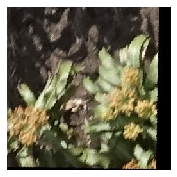

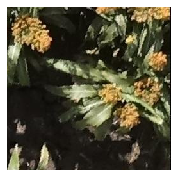

In [208]:
#Let's test this out on a single slice and plot the resulting bboxes on to our image
dl = learn.dl(DatasetType.Valid)

old_open_image = fastai.vision.data.open_image

i = 4
j = 1
original_images = list(dl.x)
setupNewCrop(i, j)

all_imgs, all_boxes = get_bounding_box_predictions(learn, dl, original_images, i,j)

fastai.vision.data.open_image = old_open_image

In [209]:
img = all_imgs[0]
bboxes = all_boxes[0]

torch.Size([1258, 341])


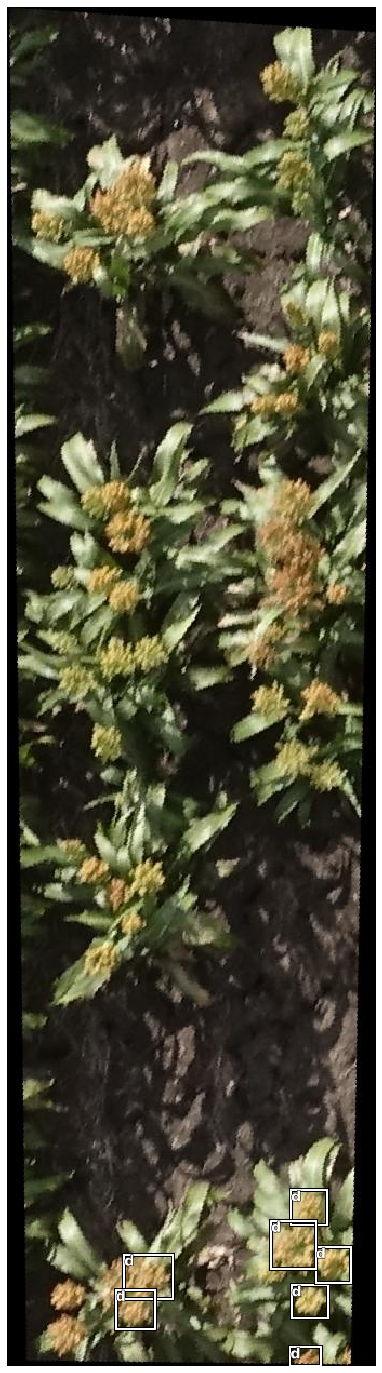

In [210]:
classId = [0 for _ in range(len(bboxes))]
bbox = ImageBBox.create(*img.size, (bboxes), classId, classes=['d'])
print(img.size)
img.show(figsize=(25,25), y=bbox)